In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# !pip install nlpaug

In [30]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import Counter

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# import nlpaug.augmenter.word as naw

import keras
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import load_model, save_model

In [31]:
# aug = naw.SynonymAug(aug_src='wordnet', lang='eng')

In [32]:
%cd /content/drive/MyDrive/Colab

data = pd.read_csv('train.csv').sort_values('label')
data.head()

/content/drive/MyDrive/Colab


,category,sub_category,name_product,star,title,comment,label
1283,Women's Fashion,Accessories,Neutrogena Makeup Remover Facial Cleansing Tow...,2,strange scent leaf face oily,use neutrogena product past like assume wipe w...,bad
2888,Women's Fashion,Shoes,"Amazon Basics Witch Hazel USP Astringent, 16 F...",1,came lid,come lid,bad
3601,Women's Fashion,Accessories,"PURA D'OR Organic Rosehip Seed Oil, 100% Pure ...",1,delivery good,product unfortunately oil rancid use rosehip f...,bad
1218,Women's Fashion,Clothing,OGX Radiant Glow + Argan Oil of Morocco Extra ...,1,impressed,body wash scent apply body also nourish regret...,bad
1217,Women's Fashion,Clothing,RoC Multi Correxion Revive + Glow 10% Vitamin ...,1,sent used product,super excited try product receive damage box l...,bad


In [33]:
X = data['comment']

def encode_label(label): 
  if label == 'bad': 
    return 0 
  elif label == 'neutral': 
    return 1 
  return 2 

y = data['label'].apply(encode_label).values

In [34]:
# x = X_train.copy()

# for i in range(1):
#   print(f'<============= Data augmention in loop {i+1} =============>')
#   augmented_sentences = [aug.augment(sentence) for sentence in x]
#   augmented_sentences = np.array(augmented_sentences).reshape(X_train.shape[0],)
#   X_train = np.concatenate((X_train, augmented_sentences), axis=0)

In [35]:
# # duplicates label  
# y_train = np.repeat(y_train, 2)

In [36]:
def tokenizer_sequences(sequence):
  # Khởi tạo tokenizer
  tokenizer = Tokenizer(num_words=10000) # 
  tokenizer.fit_on_texts(sequence)

  # Chuyển văn bản thành chuỗi các số nguyên
  sequences = tokenizer.texts_to_sequences(sequence)

  # Đảm bảo các chuỗi có cùng độ dài
  max_length = None
  sequences = pad_sequences(sequences, maxlen=max_length)

  return sequences

In [37]:
X = tokenizer_sequences(X)

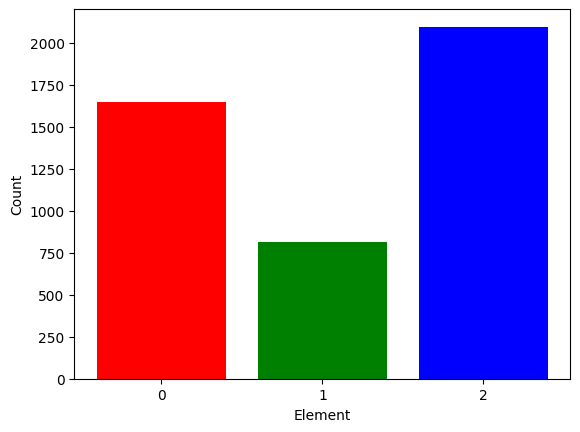

In [38]:
counter = Counter(y)
counter = dict(sorted(dict(counter).items(), key = lambda x: x[0]))

elements = list(counter.keys())
counts = list(counter.values())

colors = ['red', 'green', 'blue']
plt.bar(elements, counts, color = colors)

plt.xlabel('Element')
plt.ylabel('Count')
plt.xticks(range(len(elements)), elements[:3])

plt.show()

In [39]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)
print(f'Số lượng mẫu của tập huấn luyện sau khi xử lý mất cân bằng là {len(y_resampled)}')
X, y = X_resampled, y_resampled

Số lượng mẫu của tập huấn luyện sau khi xử lý mất cân bằng là 6285


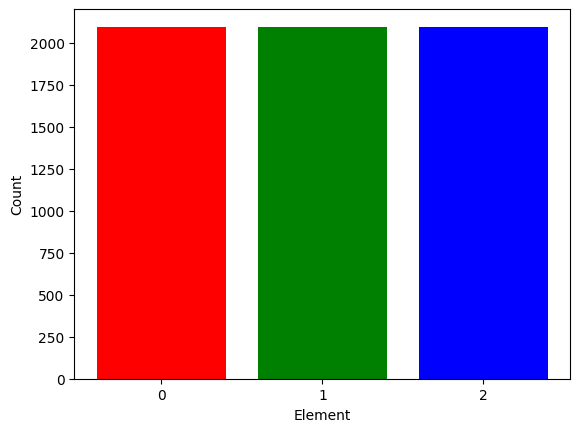

In [40]:
counter = Counter(y)
counter = dict(sorted(dict(counter).items(), key = lambda x: x[0]))

elements = list(counter.keys())
counts = list(counter.values())

colors = ['red', 'green', 'blue']
plt.bar(elements, counts, color = colors)

plt.xlabel('Element')
plt.ylabel('Count')
plt.xticks(range(len(elements)), elements[:3])

plt.show()

In [41]:
y = np_utils.to_categorical(y)

In [42]:
class PlotLosses (keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i+= 1

        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.legend()
        plt.show()
    
plot_losses = PlotLosses()

In [43]:
model = Sequential() 
model.add(Embedding(input_dim = 10000, output_dim = 128, input_length=None))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(1, 128)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(1, 128)))

model.add(Dropout(0.3))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=32))

model.add(Dropout(0.3))
model.add(Dense(units=64, activation='relu')) 
model.add(Dropout(0.2))
model.add(Dense(units=32, activation='relu')) 
model.add(Dense(units=3, activation='softmax')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         1280000   
                                                                 
 conv1d_2 (Conv1D)           (None, None, 32)          12320     
                                                                 
 conv1d_3 (Conv1D)           (None, None, 64)          6208      
                                                                 
 dropout_3 (Dropout)         (None, None, 64)          0         
                                                                 
 lstm_2 (LSTM)               (None, None, 64)          33024     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_4 (Dropout)         (None, 32)               

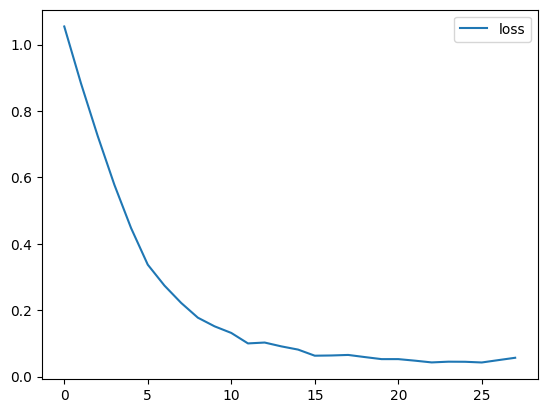

197/197 [==============================] - 9s 46ms/step - loss: 0.0568 - accuracy: 0.9804 - val_loss: 0.0354 - val_accuracy: 0.9893


In [44]:
early_stop = EarlyStopping(monitor='accuracy', patience=5)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X, y, epochs=30, batch_size=32, validation_data=(X, y), callbacks=[early_stop, plot_losses]) #aug 100 epochs

In [45]:
%cd /content/drive/MyDrive/Colab

save_model(model, 'sent_classifier.h5')

/content/drive/MyDrive/Colab


In [46]:
model_pred = load_model('sent_classifier.h5')

In [47]:
df_test = pd.read_csv('test.csv').sort_values('label')
df_test.head()

,category,sub_category,name_product,star,title,comment,label
1283,Women's Fashion,Accessories,Neutrogena Makeup Remover Facial Cleansing Tow...,2,strange scent leaf face oily,use neutrogena product past like assume wipe w...,bad
2888,Women's Fashion,Shoes,"Amazon Basics Witch Hazel USP Astringent, 16 F...",1,came lid,come lid,bad
3601,Women's Fashion,Accessories,"PURA D'OR Organic Rosehip Seed Oil, 100% Pure ...",1,delivery good,product unfortunately oil rancid use rosehip f...,bad
1218,Women's Fashion,Clothing,OGX Radiant Glow + Argan Oil of Morocco Extra ...,1,impressed,body wash scent apply body also nourish regret...,bad
1217,Women's Fashion,Clothing,RoC Multi Correxion Revive + Glow 10% Vitamin ...,1,sent used product,super excited try product receive damage box l...,bad


In [48]:
X1 = df_test['comment']

def encode_label(label): 
  if label == 'bad': 
    return 0 
  elif label == 'neutral': 
    return 1 
  return 2 

y1 = df_test['label'].apply(encode_label).values

In [49]:
def tokenizer_sequences(sequence):
  # Khởi tạo tokenizer
  tokenizer = Tokenizer(num_words=10000) # 
  tokenizer.fit_on_texts(sequence)

  # Chuyển văn bản thành chuỗi các số nguyên
  sequences = tokenizer.texts_to_sequences(sequence)

  # Đảm bảo các chuỗi có cùng độ dài
  max_length = None
  sequences = pad_sequences(sequences, maxlen=max_length)

  return sequences

X1 = tokenizer_sequences(X1)

In [50]:
y_pred = np.argmax(model_pred.predict(X1), axis=1)

143/143 [==============================] - 3s 17ms/step


In [51]:
accuracy = accuracy_score(y1, y_pred)
f1 = f1_score(y1, y_pred, average = 'macro')
recall = recall_score(y1, y_pred, average = 'macro')
precision = precision_score(y1, y_pred, average = 'macro')

print('Accuracy:', str(round(accuracy*100, 3))+'%')
print('F1-score:', str(round(f1*100, 3))+'%')
print('Recall:', str(round(recall*100, 3))+'%')
print('Precision:', str(round(precision*100, 3))+'%')

Accuracy: 99.232%
F1-score: 99.058%
Recall: 98.901%
Precision: 99.22%
